In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.spatial.distance import cdist
import time
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

2025-11-07 04:00:26.838582: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762488027.233400      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762488027.356220      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def pivoted_aca(A, tol=1e-15, max_rank=None):
    """
    Partially Pivoted ACA (PPACA).
    Approximate A ≈ U V^T without forming the full residual.
    """
    M, N = A.shape
    if max_rank is None:
        max_rank = min(M, N)

    U_list, V_list = [], []
    i = 0
    rows_available = list(range(M))
    cols_available = list(range(N))
    Rnorm_sq = np.sum(A**2)
    Snorm_sq = 0.0
    k = 0

    while k < max_rank and abs((Rnorm_sq - Snorm_sq)) / Rnorm_sq > tol:
        row = A[i, :] - sum(u[i] * v for u, v in zip(U_list, V_list))
        if i in rows_available:
            rows_available.remove(i)

        row_abs = np.abs(row)
        subset = row_abs[cols_available]
        relative_argmax = np.argmax(subset)
        j = cols_available[relative_argmax]

        if np.abs(row[j]) < 1e-14:
            break

        if j in cols_available:
            cols_available.remove(j)

        col = A[:, j] - sum(v[j] * u for u, v in zip(U_list, V_list))
        gamma = 1.0 / row[j]
        u_new = col * gamma
        v_new = row

        Snorm_sq += 2 * sum((u_new @ u) * (v_new @ v) for u, v in zip(U_list, V_list)) + np.linalg.norm(u_new)**2 * np.linalg.norm(v_new)**2

        U_list.append(u_new)
        V_list.append(v_new)

        if not rows_available:
            break

        col_abs = np.abs(col)
        subset = col_abs[rows_available]
        relative_argmax = np.argmax(subset)
        i = rows_available[relative_argmax]
        k += 1

    if not U_list:
        return np.zeros((M,0)), np.zeros((N,0))

    U = np.column_stack(U_list)
    V = np.column_stack(V_list)
    return U, V

In [3]:
class HODLR_TF:
    def __init__(self, A, tol=1e-6, min_size=32, use_aca=False):
        """
        TensorFlow HODLR decomposition of matrix A.
        If use_aca=True, uses Adaptive Cross Approximation instead of SVD.
        """
        self.n = A.shape[0]
        self.tol = tol
        self.min_size = min_size
        self.use_aca = use_aca
        self.is_leaf = self.n <= min_size

        if self.is_leaf:
            self.A = tf.constant(A, dtype=tf.float32)
            self.U12 = self.V12 = None
            self.U21 = self.V21 = None
            self.A11 = self.A22 = None
        else:
            mid = self.n // 2
            A11, A12 = A[:mid, :mid], A[:mid, mid:]
            A21, A22 = A[mid:, :mid], A[mid:, mid:]

            # Compress off-diagonal blocks
            self.U12, self.V12 = self.low_rank(A12)
            self.U21, self.V21 = self.low_rank(A21)

            # Recurse on diagonal blocks
            self.A11 = HODLR_TF(A11, tol, min_size, use_aca)
            self.A22 = HODLR_TF(A22, tol, min_size, use_aca)

    def low_rank(self, block):
        """
        Low-rank approximation using either SVD (default) or ACA.
        Returns U, V such that block ≈ U @ V.T
        """
        if self.use_aca:
            U, V = pivoted_aca(block, tol=self.tol)
            # Transpose V to keep consistent with SVD-based representation
            return tf.constant(U, dtype=tf.float32), tf.transpose(tf.constant(V, dtype=tf.float32))

        else:
            # Use SVD
            block_tf = tf.constant(block, dtype=tf.float32)
            s, U, V = tf.linalg.svd(block_tf, full_matrices=False)
            mask = s > self.tol
            r = tf.reduce_sum(tf.cast(mask, tf.int32))
            U_r = U[:, :r]
            V_r = V[:, :r]
            S_r = tf.linalg.diag(s[:r])
            return tf.matmul(U_r, S_r), tf.transpose(V_r)
    def matvec(self, x):
        """Multiply HODLR matrix by vector x (TensorFlow ops)"""
        x = tf.convert_to_tensor(x, dtype=tf.float32)

        if self.is_leaf:
            return tf.linalg.matvec(self.A, x)

        mid = self.n // 2
        x1, x2 = x[:mid], x[mid:]

        # Recursively multiply
        y1 = self.A11.matvec(x1)
        y2 = self.A22.matvec(x2)

        # Add low-rank contributions
        if self.U12 is not None:
            y1 += tf.matmul(self.U12, tf.matmul(self.V12, tf.expand_dims(x2, -1)))[:, 0]
        if self.U21 is not None:
            y2 += tf.matmul(self.U21, tf.matmul(self.V21, tf.expand_dims(x1, -1)))[:, 0]

        return tf.concat([y1, y2], axis=0)
        
    def matmat(self, X):
      X = tf.convert_to_tensor(X, dtype=tf.float32)
      if self.is_leaf:
        return tf.matmul(self.A, X)
      mid = self.n // 2
      X1, X2 = X[:mid, :], X[mid:, :]
      Y1 = self.A11.matmat(X1)
      Y2 = self.A22.matmat(X2)
      if self.U12 is not None:
        Y1 += tf.matmul(self.U12, tf.matmul(self.V12, X2))
      if self.U21 is not None:
        Y2 += tf.matmul(self.U21, tf.matmul(self.V21, X1))
      return tf.concat([Y1, Y2], axis=0)

I0000 00:00:1762488048.452991      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762488048.453820      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


n=500, time=1.697s, avg rank=1.5
n=1000, time=0.099s, avg rank=1.2
n=1500, time=0.188s, avg rank=1.1
n=2000, time=0.211s, avg rank=1.1
n=5000, time=0.808s, avg rank=1.0
n=10000, time=1.921s, avg rank=1.0


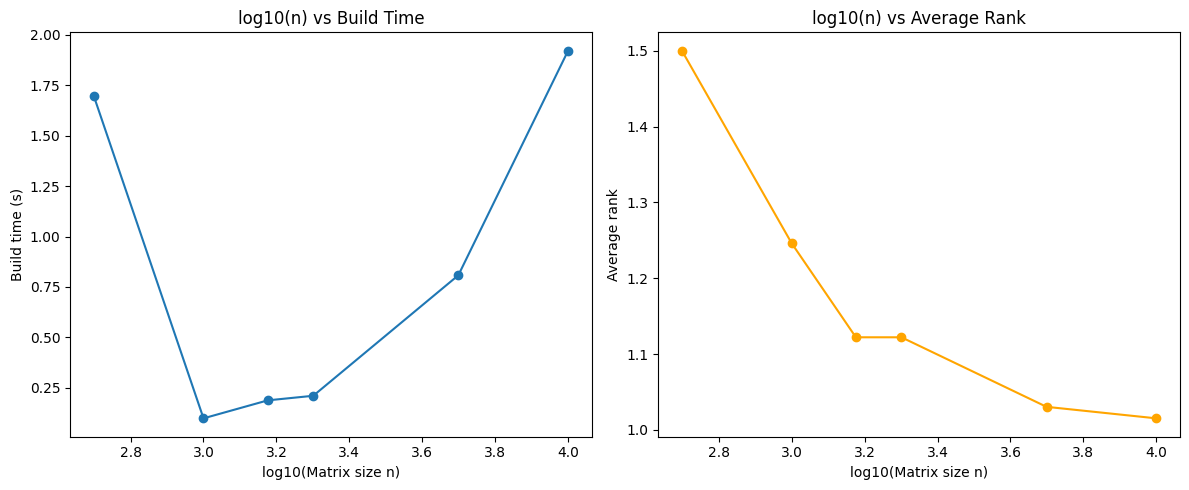

In [4]:
def benchmark_hodlr_tf(sizes, tol=1e-3, min_size=16):
    times = []
    ranks = []

    for n in sizes:
        x = np.linspace(0, 1, n)
        A = 1.0 / (1.0 + np.abs(x[:, None] - x[None, :]))

        start = time.time()
        hodlr_A = HODLR_TF(A, tol=tol, min_size=min_size,use_aca=True)
        end = time.time()

        # collect ranks iteratively
        stack = [hodlr_A]
        all_ranks = []
        while stack:
            node = stack.pop()
            if not node.is_leaf:
                if node.U12 is not None:
                    all_ranks.append(node.U12.shape[1])
                if node.U21 is not None:
                    all_ranks.append(node.U21.shape[1])
                stack.append(node.A11)
                stack.append(node.A22)

        avg_rank = np.mean(all_ranks) if all_ranks else 0
        times.append(end - start)
        ranks.append(avg_rank)

        print(f"n={n}, time={times[-1]:.3f}s, avg rank={avg_rank:.1f}")

    return times, ranks

# Run benchmarks
sizes = [500, 1000, 1500, 2000, 5000, 10000]
times, ranks = benchmark_hodlr_tf(sizes, tol=1e-3, min_size=16)

# Plotting with log scales
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(np.log10(sizes), times, marker="o")
plt.xlabel("log10(Matrix size n)")
plt.ylabel("Build time (s)")
plt.title("log10(n) vs Build Time")

plt.subplot(1, 2, 2)
plt.plot(np.log10(sizes), ranks, marker="o", color="orange")
plt.xlabel("log10(Matrix size n)")
plt.ylabel("Average rank")
plt.title("log10(n) vs Average Rank")

plt.tight_layout()
plt.show()

In [5]:
class GaussianProcessRegression:
    def __init__(self, kernel_fn, noise_level=1e-4):
        self.kernel_fn = kernel_fn
        self.noise_level = noise_level
        self.X_train = None
        self.y_train = None
        self.alpha = None
        self.hodlr_matrix = None
        
    def fit(self, X, y):
        # Convert inputs to float32 for TensorFlow compatibility
        self.X_train = X.astype(np.float32)
        self.y_train = y.astype(np.float32)
        n = len(X)
        
        # Build kernel matrix using HODLR structure
        print(f"Building kernel matrix of size {n}x{n}...")
        K = self.kernel_fn(X, X).astype(np.float32)
        self.hodlr_matrix = HODLR_TF(K, tol=1e-3, min_size=16,use_aca=True)
        
        # Solve (K + σ²I)α = y using conjugate gradient
        print("Solving linear system with conjugate gradient...")
        def matvec(x):
            # Ensure x is converted to TensorFlow tensor
            x_tf = tf.convert_to_tensor(x, dtype=tf.float32)
            return self.hodlr_matrix.matvec(x_tf) + self.noise_level * x_tf
            
        self.alpha = self.conjugate_gradient(matvec, self.y_train)
        print("Training completed!")
        
    def conjugate_gradient(self, A_matvec, b, max_iter=100, tol=1e-6):
        """Conjugate gradient method using HODLR matrix-vector products"""
        # Convert b to TensorFlow tensor
        b = tf.convert_to_tensor(b, dtype=tf.float32)
        n = b.shape[0]
        x = tf.zeros_like(b)
        r = b - A_matvec(x)
        p = r
        rs_old = tf.reduce_sum(r * r)
        
        for i in range(max_iter):
            Ap = A_matvec(p)
            alpha = rs_old / tf.reduce_sum(p * Ap)
            x = x + alpha * p
            r = r - alpha * Ap
            rs_new = tf.reduce_sum(r * r)
            
            if i % 10 == 0:
                print(f"CG iteration {i}, residual: {tf.sqrt(rs_new).numpy():.6f}")
            
            if tf.sqrt(rs_new) < tol:
                print(f"CG converged after {i} iterations")
                break
                
            p = r + (rs_new / rs_old) * p
            rs_old = rs_new
            
        return x.numpy()
        
    def predict(self, X_test):
        print("Making predictions...")
        # Convert test data to float32
        X_test = X_test.astype(np.float32)
        
        # Compute kernel matrices
        K_star = self.kernel_fn(X_test, self.X_train).astype(np.float32)
        K_star_star = self.kernel_fn(X_test, X_test).astype(np.float32)
        
        # Compute predictive mean
        f_mean = K_star @ self.alpha
        
        # Compute predictive variance using conjugate gradient
        # For each test point, we need to solve (K + σ²I) v = k_star
        # Then variance = k_star_star - k_star^T v
        f_var = np.zeros(len(X_test), dtype=np.float32)
        
        # Precompute the diagonal of K_star_star
        k_star_star_diag = np.diag(K_star_star)
        
        # For each test point, solve the linear system
        for i in range(len(X_test)):
            k_star_i = K_star[i:i+1, :].T  # Column vector
            
            # Solve (K + σ²I) v = k_star_i using conjugate gradient
            v = self.conjugate_gradient(
                lambda x: self.hodlr_matrix.matvec(x) + self.noise_level * x,
                k_star_i.flatten()
            )
            
            # Compute variance for this test point
            f_var[i] = k_star_star_diag[i] - k_star_i.T @ v
        
        return f_mean, f_var

# Kernel functions
def cauchy_kernel(X1, X2):
    return 1.0 / (1.0 + cdist(X1, X2, metric='cityblock'))

def rbf_kernel(X1, X2, length_scale=1.0):
    dists = cdist(X1, X2, metric='sqeuclidean')
    return np.exp(-0.5 * dists / (length_scale ** 2))

Fitting Gaussian Process Regression...
Building kernel matrix of size 500x500...
Solving linear system with conjugate gradient...
CG iteration 0, residual: 4.415469
CG iteration 10, residual: 5.445450
CG iteration 20, residual: 0.520327
CG iteration 30, residual: 0.231806
CG iteration 40, residual: 0.080886
CG iteration 50, residual: 0.016329
CG iteration 60, residual: 0.004670
CG iteration 70, residual: 0.001301
CG iteration 80, residual: 0.001320
CG iteration 90, residual: 0.001066
Training completed!
Making predictions...
CG iteration 0, residual: 2.920369
CG iteration 10, residual: 0.304446
CG iteration 20, residual: 0.065821
CG iteration 30, residual: 0.013898
CG iteration 40, residual: 0.017066
CG iteration 50, residual: 0.002467
CG iteration 60, residual: 0.001087
CG iteration 70, residual: 0.000260
CG iteration 80, residual: 0.000238
CG iteration 90, residual: 0.000071
CG iteration 0, residual: 2.910999
CG iteration 10, residual: 0.209388
CG iteration 20, residual: 0.049297
CG 

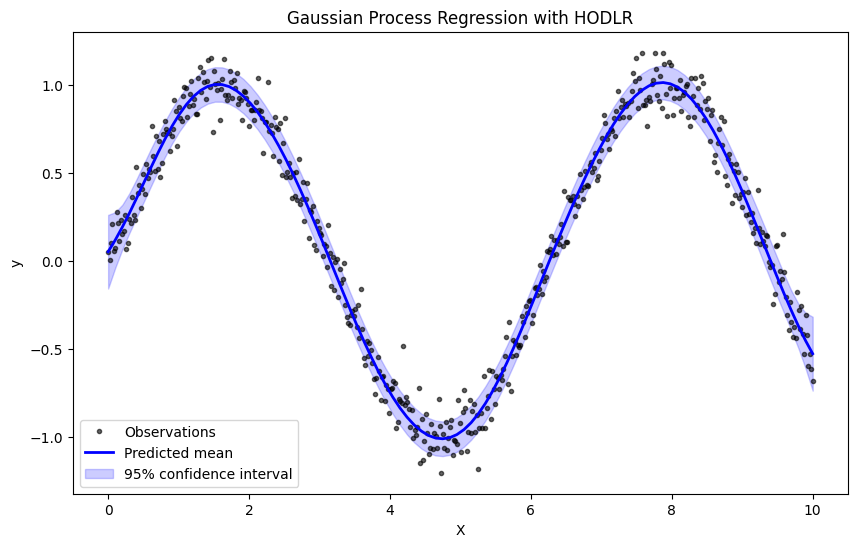

In [6]:
# Example usage and testing
# Generate sample data
np.random.seed(42)
n_train = 500
n_test = 100

X_train = np.linspace(0, 10, n_train)[:, None]
y_train = np.sin(X_train).flatten() + 0.1 * np.random.randn(n_train)

X_test = np.linspace(0, 10, n_test)[:, None]

# Fit GPR model
print("Fitting Gaussian Process Regression...")
gpr = GaussianProcessRegression(rbf_kernel, noise_level=0.1)
gpr.fit(X_train, y_train)

# Make predictions
y_mean, y_var = gpr.predict(X_test)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(X_train, y_train, 'k.', label='Observations', alpha=0.6)
plt.plot(X_test, y_mean, 'b-', label='Predicted mean', linewidth=2)
plt.fill_between(
    X_test.flatten(),
    y_mean - 2 * np.sqrt(y_var),
    y_mean + 2 * np.sqrt(y_var),
    alpha=0.2,
    color='blue',
    label='95% confidence interval'
)
plt.legend()
plt.xlabel('X')
plt.ylabel('y')
plt.title('Gaussian Process Regression with HODLR')
plt.show()

Running GPR benchmark for multiple sizes...
Building kernel matrix of size 1000x1000...
Solving linear system with conjugate gradient...
CG iteration 0, residual: 6.157302
CG iteration 10, residual: 17.856840
CG iteration 20, residual: 4.079403
CG iteration 30, residual: 0.547523
CG iteration 40, residual: 0.272885
CG iteration 50, residual: 0.224264
CG iteration 60, residual: 0.088183
CG iteration 70, residual: 0.034380
CG iteration 80, residual: 0.016221
CG iteration 90, residual: 0.003841
Training completed!
Making predictions...
CG iteration 0, residual: 4.134896
CG iteration 10, residual: 0.455439
CG iteration 20, residual: 0.115529
CG iteration 30, residual: 0.030155
CG iteration 40, residual: 0.046543
CG iteration 50, residual: 0.007944
CG iteration 60, residual: 0.007645
CG iteration 70, residual: 0.001620
CG iteration 80, residual: 0.001699
CG iteration 90, residual: 0.001454
CG iteration 0, residual: 4.123386
CG iteration 10, residual: 0.310764
CG iteration 20, residual: 0.08

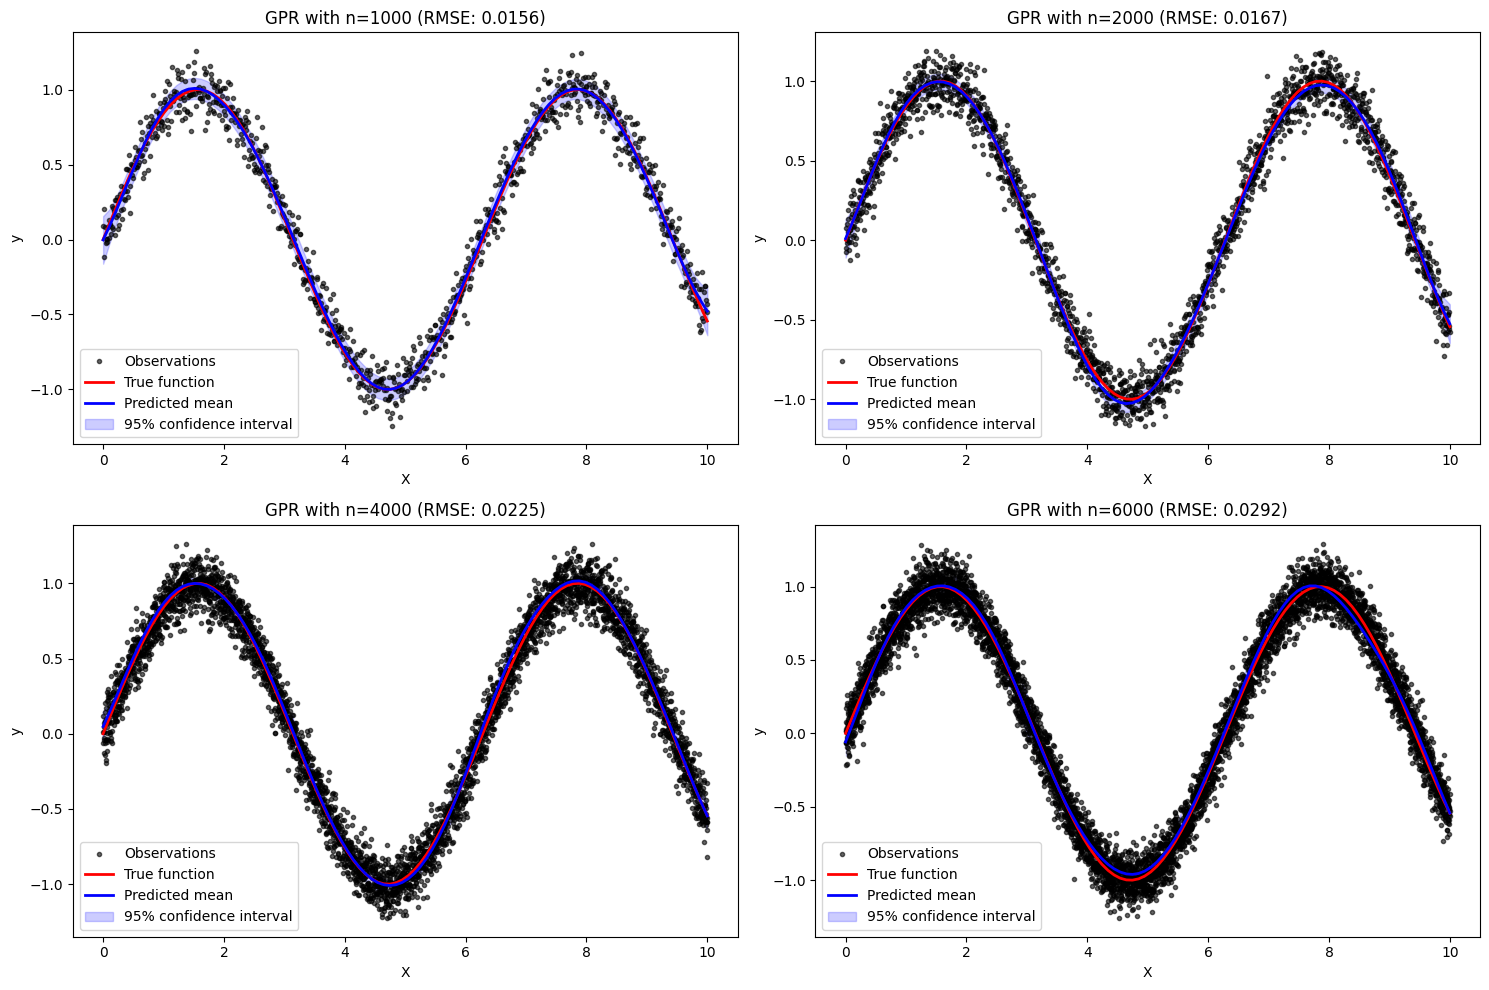

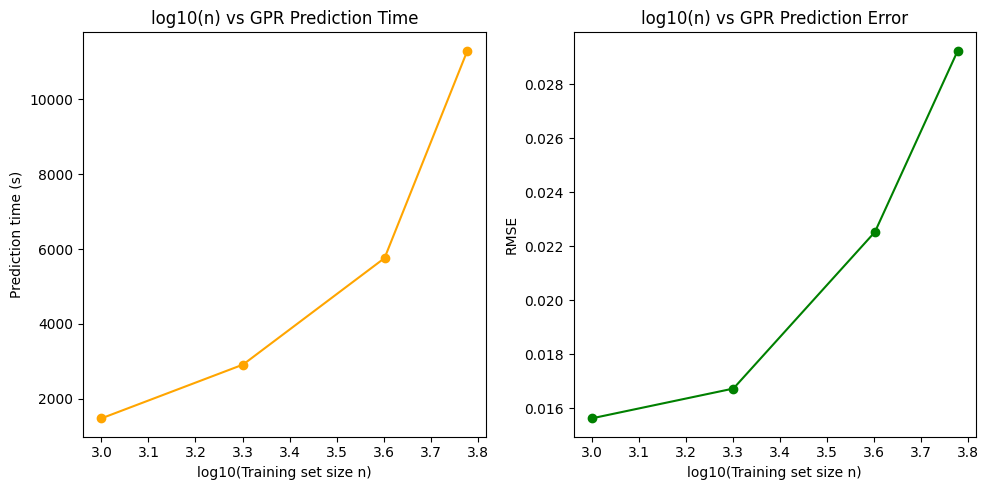

In [7]:
# Benchmark function for GPR
def benchmark_gpr(sizes, kernel_fn, noise_level=0.1):
    predict_times = []
    rmse_scores = []
    all_predictions = []
    
    # Create a fixed test set for consistent evaluation
    X_test = np.linspace(0, 10, 100)[:, None]
    y_test_true = np.sin(X_test).flatten()
    
    for n in sizes:
        # Generate sample data
        X_train = np.linspace(0, 10, n)[:, None]
        y_train = np.sin(X_train).flatten() + 0.1 * np.random.randn(n)

        # Create and fit GPR model
        gpr = GaussianProcessRegression(kernel_fn, noise_level)
        
        # Fit the model (no timing)
        gpr.fit(X_train, y_train)
        
        # Time prediction and evaluate
        start_predict = time.time()
        y_mean, y_var = gpr.predict(X_test)
        end_predict = time.time()
        predict_times.append(end_predict - start_predict)
        
        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_test_true, y_mean))
        rmse_scores.append(rmse)
        
        # Store predictions for plotting
        all_predictions.append((X_train, y_train, X_test, y_mean, y_var, y_test_true, rmse))
        
        print(f"n={n}, predict_time={predict_times[-1]:.3f}s, RMSE={rmse:.4f}")
    
    return predict_times, rmse_scores, all_predictions

# Example usage and testing
if __name__ == "__main__":
    # Run GPR benchmark for multiple sizes
    gpr_sizes = [1000, 2000, 4000, 6000]
    print("Running GPR benchmark for multiple sizes...")
    gpr_predict_times, gpr_rmse_scores, all_predictions = benchmark_gpr(gpr_sizes, rbf_kernel)

    # Plot observation plots for all n's (dynamic subplot grid)
    n_plots = len(gpr_sizes)
    n_cols = 2
    n_rows = int(np.ceil(n_plots / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.ravel()
    
    for i, (size, (X_train, y_train, X_test, y_mean, y_var, y_test_true, rmse)) in enumerate(zip(gpr_sizes, all_predictions)):
        axes[i].plot(X_train, y_train, 'k.', label='Observations', alpha=0.6)
        axes[i].plot(X_test, y_test_true, 'r-', label='True function', linewidth=2)
        axes[i].plot(X_test, y_mean, 'b-', label='Predicted mean', linewidth=2)
        axes[i].fill_between(
            X_test.flatten(),
            y_mean - 2 * np.sqrt(y_var),
            y_mean + 2 * np.sqrt(y_var),
            alpha=0.2,
            color='blue',
            label='95% confidence interval'
        )
        axes[i].set_xlabel('X')
        axes[i].set_ylabel('y')
        axes[i].set_title(f'GPR with n={size} (RMSE: {rmse:.4f})')
        axes[i].legend()
    
    # Hide unused subplots if grid > number of plots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    # Plotting GPR benchmark results (predict time and RMSE only)
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(np.log10(gpr_sizes), gpr_predict_times, marker="o", color="orange")
    plt.xlabel("log10(Training set size n)")
    plt.ylabel("Prediction time (s)")
    plt.title("log10(n) vs GPR Prediction Time")

    plt.subplot(1, 2, 2)
    plt.plot(np.log10(gpr_sizes), gpr_rmse_scores, marker="o", color="green")
    plt.xlabel("log10(Training set size n)")
    plt.ylabel("RMSE")
    plt.title("log10(n) vs GPR Prediction Error")

    plt.tight_layout()
    plt.show()